En este notebook muestro alguno de los modelos que probé

# Preparar datos

In [2]:
import pandas as pd
import numpy as np

import json
def build_dataset():
    data = [json.loads(x) for x in open("MLA_100k.jsonlines")]
    target = lambda x: x.get("condition")
    N = -10000
    X_train = data[:N]
    X_test = data[N:]
    y_train = [target(x) for x in X_train]
    y_test = [target(x) for x in X_test]
    for x in X_test:
        del x["condition"]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = build_dataset()

tabla_train=pd.DataFrame.from_dict(X_train, orient='columns') #las keys son las columnas

tabla_train=(tabla_train[['title','seller_id','price','warranty','listing_type_id','initial_quantity','sold_quantity','category_id','condition']]
        .astype({'seller_id':'object'}))

tabla_test=pd.DataFrame.from_dict(X_test, orient='columns')[['title','seller_id','price','warranty','listing_type_id','initial_quantity','sold_quantity','category_id']] #las keys son las columnas

In [3]:
def label_encoder(s):
    if s=='new':
        return 1
    else:
        return 0
    
y_train_encoded=np.array(list(map(label_encoder,y_train)))

y_test_encoded=np.array(list(map(label_encoder,y_test)))

In [6]:
# datos

#texto
import nltk
from nltk.corpus import stopwords

sw=stopwords.words('spanish')
sw.remove('sin')
sw.remove('con')

from sklearn.feature_extraction.text import CountVectorizer
vectorizador_bow=CountVectorizer(stop_words=sw)

x_train_bow=vectorizador_bow.fit_transform(tabla_train['title'])

from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
x_train_tfidf = tfidf_transformer.fit_transform(x_train_bow)

x_test_bow = vectorizador_bow.transform(tabla_test['title'])
x_test_tfidf = tfidf_transformer.transform(x_test_bow)


#features
 #sumamos uno para que los codigos empiecen en 1 y no en 0
cat_codes=tabla_train['category_id'].astype('category').cat.codes + 1
list_codes=tabla_train['listing_type_id'].astype('category').cat.codes + 1


from collections import defaultdict #le damos un valor por defecto

encoder_cat = {key:value for (key,value) in np.array([tabla_train['category_id'],cat_codes]).T}
encoder_cat=defaultdict(int ,encoder_cat)
decoder_cat = {value:key for (key,value) in encoder_cat.items()}
decoder_cat=defaultdict(int ,decoder_cat)

encoder_type = {key:value for (key,value) in np.array([tabla_train['listing_type_id'],cat_codes]).T}
encoder_type=defaultdict(int ,encoder_type)
decoder_type = {value:key for (key,value) in encoder_cat.items()}
decoder_type=defaultdict(int ,decoder_type)

x_train_sc = (
            np.array([tabla_train['category_id'].map(encoder_cat),
                      tabla_train['listing_type_id'].map(encoder_type)])
            ).T

x_train_features = pd.concat([pd.DataFrame(x_train_sc),tabla_train['initial_quantity'], tabla_train['sold_quantity']],axis=1).to_numpy()


x_test_sc = (np.array([#tabla_test['seller_id'].map(encoder_seller,), 
                       tabla_test['category_id'].map(encoder_cat),
                      tabla_test['listing_type_id'].map(encoder_type)]).T
            )
x_test_features = pd.concat([pd.DataFrame(x_test_sc),tabla_test['initial_quantity'], tabla_test['sold_quantity']],axis=1).to_numpy()


In [17]:
from scipy.sparse import hstack # para concatenar matrices esparsas y densas
x_train = hstack([x_train_tfidf,x_train_features])
x_test = hstack([x_test_tfidf,x_test_features])

# Baseline

Un modelo de ml clásico (o sea no deep learning) que solo toma en cuenta los textos

In [8]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB().fit(x_train_tfidf, y_train)

In [10]:
y_pred = nb.predict(x_test_tfidf)

In [14]:
acc_nb= (y_pred == y_test).sum()/len(y_test)
acc_nb

0.7937

# Modelo elegido

Después de probar algún otro modelo con las palabras (como una red) y otros modelos con las features que no son palabras
tratamos de armar uno con todos los datos. Hay variables categoricas y númericas, un arbol de decisión es una forma efectiva de mezclar ambas


Igual tenemos que encodear las variables categoricas porque sklearn solo permite variables numéricas en los modelos, pero podemos simplemente encondearlas con un diccionario

In [24]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(max_depth = 40).fit(x_train, y_train_encoded)

Si se deja que el arbol sea tan profundo como quiera entonces se llega a una accuracy casi del 100% en train, el modelo se overfittea.
La idea de cortarlo es llegar a un compromiso entre una buena acc en test y una no tan extremadamente alta en train. Al `max_depth = 40` llegamos probando

In [25]:
# en train
y_pred_train = tree.predict(x_train)
acc_tree_train= (y_pred_train == y_train_encoded).sum()/len(y_train_encoded)
acc_tree_train

0.9416333333333333

In [26]:
y_pred_test = tree.predict(x_test)
acc_tree_test= (y_pred_test == y_test_encoded).sum()/len(y_test_encoded)
acc_tree_test

0.8646

# Tratar de superarlo: redes neuronales

Traté de mejorar la performance y para eso probé con redes neuronales con dos clases de input: los títulos (encodeados y pasados por una capa de embedding) y con el resto de las features elegidas.

Para usar ambos al mismo tiempo usamos la api funcional de keras

## Preparar datos

No usamos el tf-idf que ya teníamos, encodeamos con un diccionario (palabra:numero) ya que de darle un sentido a la representación vectorial de los textos se va a encargar la capa de embedding de keras

In [30]:
import re
import unicodedata
import nltk
from nltk.corpus import stopwords

sw=stopwords.words('spanish')
sw.remove('sin')
sw.remove('con')

#saquemos stopwords
sentences_train = (tabla_train['title']
                     .apply(str.lower)
                     .apply(lambda s: unicodedata.normalize("NFKD", s).encode("ASCII", "ignore").decode("ASCII"))
                     .apply(lambda s: re.findall('\w*',s)) #me qeudo solo con las palabras
                     .apply(lambda lista: filter(lambda s: s not in sw,lista))
                     .apply(lambda filtrada: ' '.join(filtrada))
                    )

#saquemos stopwords
sentences_test = (tabla_test['title']
                     .apply(str.lower)
                          #remover acentos
                     .apply(lambda s: unicodedata.normalize("NFKD", s).encode("ASCII", "ignore").decode("ASCII"))
                     .apply(lambda s: re.findall('\w*',s)) #me qeudo solo con las palabras
                     .apply(lambda lista: filter(lambda s: s not in sw,lista))
                     .apply(lambda filtrada: ' '.join(filtrada))
                 )

from keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer() # se sacan todos estos simbolos !"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n
tokenizer.fit_on_texts(sentences_train)

x_train= tokenizer.texts_to_sequences(sentences_train)
x_test = tokenizer.texts_to_sequences(sentences_test)

print(sentences_train[2])
print(x_train[2])

antigua  revista  billiken   n  1826   ano  1954 
[23, 22, 2577, 53, 22347, 42, 2446]


In [31]:
#hay que hacer un padding, el largo promedio es 7.5 y la mediana es 8, el maximo es del orden de las 40 palabras
from keras.preprocessing.sequence import pad_sequences

maxlen = 15

x_train_texts = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test_texts = pad_sequences(x_test, padding='post', maxlen=maxlen)

print(x_train_texts[0, :])

[ 768   30  150  860 1345   89  103   45    0    0    0    0    0    0
    0]


Así que cada texto ahora es un vector de largo 15 en el que las palabras fueron reemplazadas por un número que cada una tiene asignado

## Red densa

In [35]:
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
embedding_dim = 100

In [36]:
from keras.callbacks import EarlyStopping #para parar en caso de que la val_loss suba

early_stopping = EarlyStopping(monitor='val_loss', patience=1)

In [37]:
from keras import Input,layers,Model

#entradas
textos_input = Input(shape=(15), name='textos')
features_input = Input(shape=(4), name='features')

#embedding
x = layers.Embedding(vocab_size, embedding_dim)(textos_input)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(200, activation='relu')(x)

#usamos las features
z = layers.Dense(200, activation='relu')(features_input)

#concatenamos (solo hace esto esta layer)
merge = layers.concatenate([x, z])

# parte conjunta
merge = layers.Dense(200,activation='relu')(merge)
merge = layers.Dropout(rate=0.1)(merge) #dropout para evitar overfitting
merge = layers.Dense(200, activation='relu')(merge)

output = layers.Dense(1, activation='sigmoid', name='salida')(merge)

model = Model(
    inputs=[textos_input, features_input],
    outputs=[output],
)

2021-09-09 11:22:18.005234: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-09 11:22:18.008005: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 30364400 exceeds 10% of free system memory.
2021-09-09 11:22:18.029627: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 30364400 exceeds 10% of free system memory.
2021-09-09 11:22:18.035062: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 30364400 exceeds 10% of free system memory.


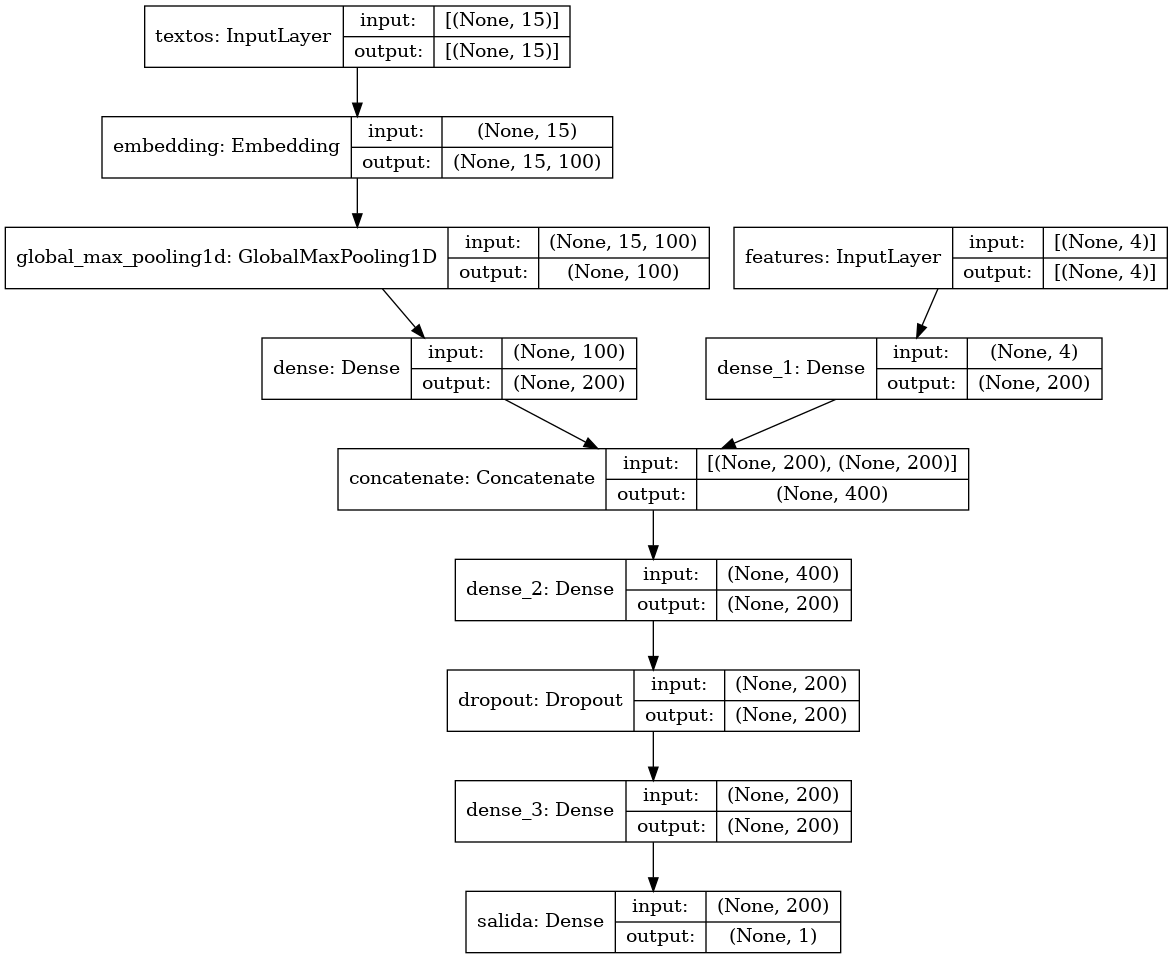

In [39]:
from keras.utils import plot_model #se necesita una libreria de grafos para usarlo
plot_model(model, "densa.png", show_shapes=True)

In [41]:
from keras.optimizers import Adam

#en un momento parecia que se overfitteaba, mucha acc en train pero se estancaba en val
optimizer = Adam(learning_rate=0.0001) #es 10 veces mas baja que la por defecto

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
        {"textos": x_train_texts, "features": x_train_features},
        {"salida": y_train_encoded},
        epochs=10,
        batch_size=50,
        validation_split=0.1,
        callbacks=[early_stopping]
    )

2021-09-09 11:25:16.093758: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-09-09 11:25:16.113069: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1190400000 Hz
2021-09-09 11:25:16.226412: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 30364400 exceeds 10% of free system memory.
2021-09-09 11:25:16.232346: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 30364400 exceeds 10% of free system memory.


Epoch 1/10
1620/1620 [==============================] - 76s 47ms/step - loss: 13.4139 - accuracy: 0.6102 - val_loss: 0.8441 - val_accuracy: 0.6917
Epoch 2/10
1620/1620 [==============================] - 71s 44ms/step - loss: 1.2103 - accuracy: 0.6570 - val_loss: 0.5865 - val_accuracy: 0.7148
Epoch 3/10
1620/1620 [==============================] - 74s 46ms/step - loss: 0.6086 - accuracy: 0.7198 - val_loss: 0.4625 - val_accuracy: 0.8078
Epoch 4/10
1620/1620 [==============================] - 79s 49ms/step - loss: 0.4140 - accuracy: 0.8122 - val_loss: 0.4235 - val_accuracy: 0.7803
Epoch 5/10
1620/1620 [==============================] - 76s 47ms/step - loss: 0.3469 - accuracy: 0.8469 - val_loss: 0.3915 - val_accuracy: 0.8537
Epoch 6/10
1620/1620 [==============================] - 74s 46ms/step - loss: 0.3060 - accuracy: 0.8726 - val_loss: 0.3879 - val_accuracy: 0.8438
Epoch 7/10
1620/1620 [==============================] - 70s 43ms/step - loss: 0.2752 - accuracy: 0.8882 - val_loss: 0.4221 

In [43]:
# lo evaluamos
loss, accuracy = model.evaluate(x={"textos": x_train_texts, "features": x_train_features},
                                y=y_train_encoded, 
                                verbose=True)
print("Accuracy en train:",accuracy)

loss, accuracy = model.evaluate(x={"textos": x_test_texts, "features": x_test_features},
                                y=y_test_encoded, 
                                verbose=True)
print("Accuracy en test:",accuracy)

2813/2813 [==============================] - 3s 1ms/step - loss: 0.2636 - accuracy: 0.9146
Accuracy en train: 0.9145777821540833
313/313 [==============================] - 0s 1ms/step - loss: 0.3437 - accuracy: 0.8615
Accuracy en test: 0.8615000247955322


Y la red no pudo superar al decision tree, incluso después de probar un poco con la arquitectura de la misma (aunque no estuvo lejos, pero tarda más en entrenarse). Tampoco se pudo superar usando arquitecturas más complicadas como la que sigue:

# Red TCN

Esta la saque de acá: https://towardsdatascience.com/deep-learning-techniques-for-text-classification-78d9dc40bf7c

In [44]:
from keras import Input,layers,Model
from tcn import TCN, tcn_full_summary

textos_input = Input( shape=(maxlen,), name='textos')
features_input = Input(shape=(4), name='features')



##### ARQUITECTURA COPIADA Y PEGADA #####
x = layers.Embedding(input_dim=vocab_size, 
              output_dim=embedding_dim, 
              input_length=maxlen,)(textos_input)

x = layers.SpatialDropout1D(0.1)(x)

x = TCN(128,dilations = [1, 2, 4], return_sequences=True, activation = 'relu', name = 'tcn1')(x)
x = TCN(64,dilations = [1, 2, 4], return_sequences=True, activation = 'relu', name = 'tcn2')(x)

avg_pool = layers.GlobalAveragePooling1D()(x)
max_pool = layers.GlobalMaxPooling1D()(x)

x_conc = layers.concatenate([avg_pool, max_pool])
x_conc = layers.Dense(200, activation="relu")(x_conc)
#############################


#SEGUNDA ENTRADA usamos las features
z = layers.Dense(200, activation='relu')(features_input)

#concatenamos
merge = layers.concatenate([x_conc, z])

# parte conjunta
merge = layers.Dense(200,activation='relu')(merge)
merge = layers.Dropout(rate=0.1)(merge)
merge = layers.Dense(200, activation='relu')(merge)
merge = layers.Dropout(rate=0.1)(merge)
merge = layers.Dense(200, activation='relu')(merge)

output = layers.Dense(1, activation='sigmoid', name='salida')(merge) 

model = Model(
    inputs=[textos_input, features_input],
    outputs=output,
)

model.compile( loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

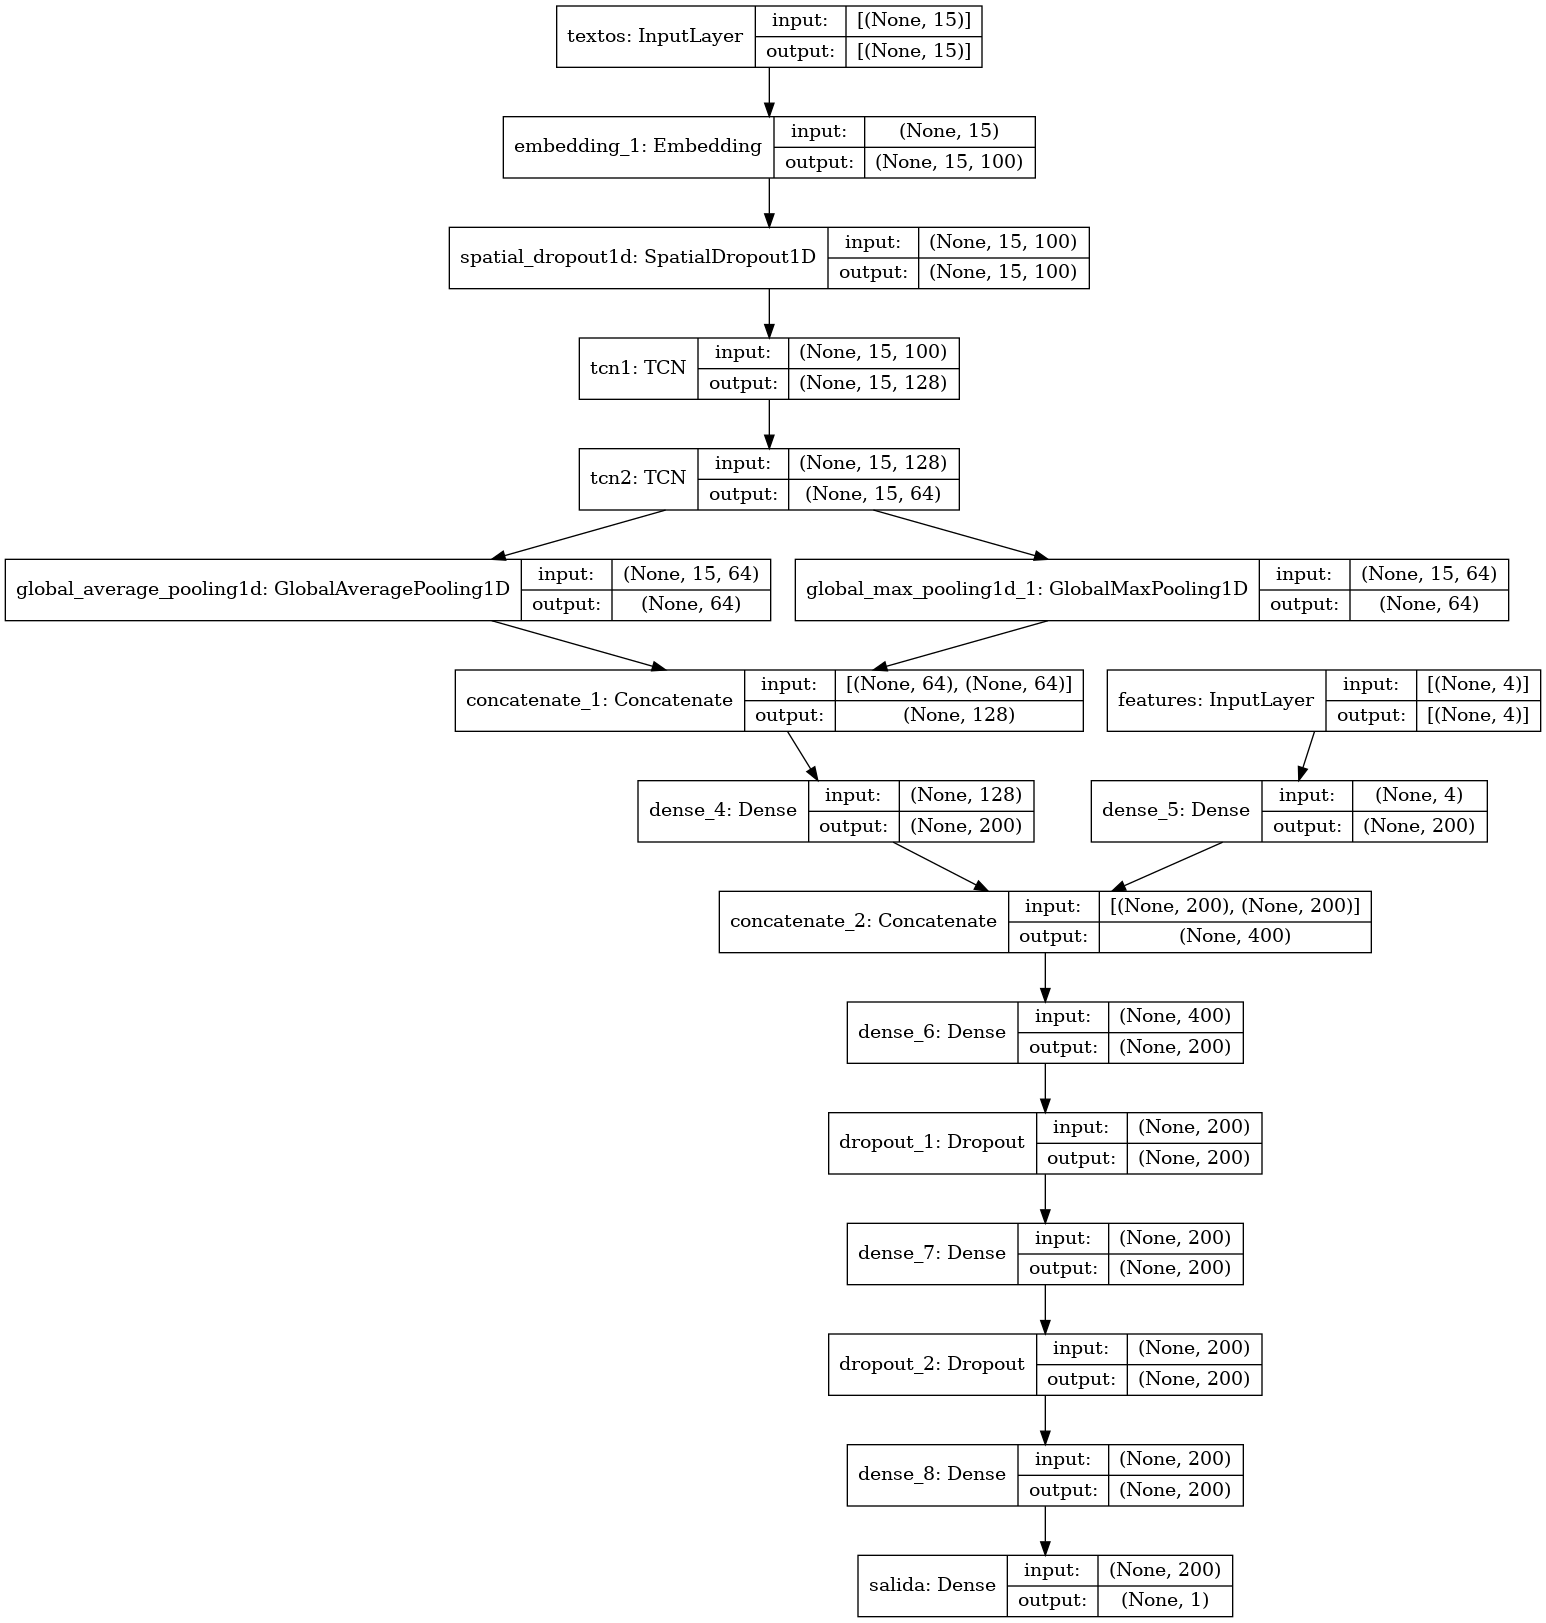

In [45]:
from keras.utils import plot_model
plot_model(model, "TCN.png", show_shapes=True)

In [46]:
history = model.fit(
        {"textos": x_train_texts, "features": x_train_features},
        {"salida": y_train_encoded},
        epochs=10,
        batch_size=50,
        validation_split=0.1,
        callbacks=[early_stopping]
    )

Epoch 1/10
1620/1620 [==============================] - 118s 72ms/step - loss: 5.3265 - accuracy: 0.6768 - val_loss: 0.4365 - val_accuracy: 0.8080
Epoch 2/10
1620/1620 [==============================] - 118s 73ms/step - loss: 0.4194 - accuracy: 0.8095 - val_loss: 0.4187 - val_accuracy: 0.8248
Epoch 3/10
1620/1620 [==============================] - 119s 73ms/step - loss: 0.3566 - accuracy: 0.8451 - val_loss: 0.4153 - val_accuracy: 0.8256
Epoch 4/10
1620/1620 [==============================] - 119s 73ms/step - loss: 0.3066 - accuracy: 0.8723 - val_loss: 0.4915 - val_accuracy: 0.8374


In [49]:
loss, accuracy = model.evaluate(x={"textos": x_train_texts, "features": x_train_features},
                                y=y_train_encoded, 
                                verbose=True)
print("Accuracy en train:",accuracy)


loss, accuracy = model.evaluate(x={"textos": x_test_texts, "features": x_test_features},
                                y=y_test_encoded, 
                                verbose=True)
print("Accuracy en test:",accuracy)

2813/2813 [==============================] - 16s 6ms/step - loss: 0.2958 - accuracy: 0.8825
Accuracy en train: 0.8825111389160156
313/313 [==============================] - 2s 6ms/step - loss: 0.4805 - accuracy: 0.8403
Accuracy en test: 0.8403000235557556


Pienso que probando más, quizas encodeando distinto las features, se podría haber superado al decision tree